In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter
from scipy.stats.mstats import pearsonr
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pandas as pd
import polychrom
import os
from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file
import matplotlib.pyplot as plt
from scipy import ndimage
import matplotlib.ticker as ticker
import cooltools
import warnings
import h5py 
import glob
import ast

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/lib/numutils.py:11: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from ._numutils import (
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/api/expected.py:14: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from cooler.tools import partition


In [2]:
path_dict = {}

directory = '/scratch1/rahmanin/dynamical_boundary_simulations/simulation_md/simulation_with_pause_mod/simulations_with_hsteps/'
#directory = '../sims/'
for name  in glob.glob(directory+'sims_o/folder_*'):
    path_dict[name.split('/sims_o/')[1][:]]= name
path_dict = dict(sorted(path_dict.items()))

### with revised pass loops

In [3]:
def find_ctcf_conv_pair(ctcf_right, ctcf_left, kmer):
    # finding pairs of ctcf elements which are convergent
    # ctcf right and lefts are right barreirs and left barriers
    # kmer: how many barreir element between convergent elements, kmer=1 is directly connected, kmer=2 is when there is an element between them
    ctot = np.sort(np.array(ctcf_right+ ctcf_left))
    ctot_pair_conv = [[ctot[i],ctot[i+kmer]] for i in range(len(ctot)-kmer) if ctot[i] in ctcf_left and ctot[i+kmer] in ctcf_right]
    return ctot_pair_conv
ctcfrightlist = [314, 579, 1195, 3717, 3772, 3921, 4451, 5193, 5723, 6302, 6574, 6779, 7000, 9232, 9310, 9861]
ctcfleftlist = [495, 865, 1404, 2164, 3143, 3615, 3971, 4069, 4480, 4938, 5300, 5587, 6401, 7725, 8764, 9619]
ctcflist = np.array(ctcfrightlist + ctcfleftlist)
duplication = np.array(np.arange(0, 100000, 10000))
ctcflist_t = np.sort(np.concatenate([ctcflist+ base for base in duplication]))
ctcflist = ctcflist_t
ctcfrightlist
duplication = np.array(np.arange(0, 100000, 10_000))
ctcfrightlist_t = np.sort(np.concatenate([ctcfrightlist+ base for base in duplication]))
ctcfleftlist_t = np.sort(np.concatenate([ctcfleftlist+base for base in duplication]))

def find_normalizers(ctcf_right=list(ctcfrightlist_t), ctcf_left=list(ctcfleftlist_t), n_frames=100):
    normalizer = {}
    for kmer in [1,2,3,4,5,6,7]:
        normalizer['%s_kmer'%(kmer)]=n_frames*len(find_ctcf_conv_pair(ctcf_right, ctcf_left,kmer))
    return normalizer

In [4]:
### obtainging normalizer factors
len_lefs = 1000000
normalizer_factor = find_normalizers(n_frames=len(range(len_lefs//3, len_lefs, 1)))
normalizer_factor

{'1_kmer': 60000030,
 '2_kmer': 66000033,
 '3_kmer': 46666690,
 '4_kmer': 52666693,
 '5_kmer': 59333363,
 '6_kmer': 58666696,
 '7_kmer': 46000023}

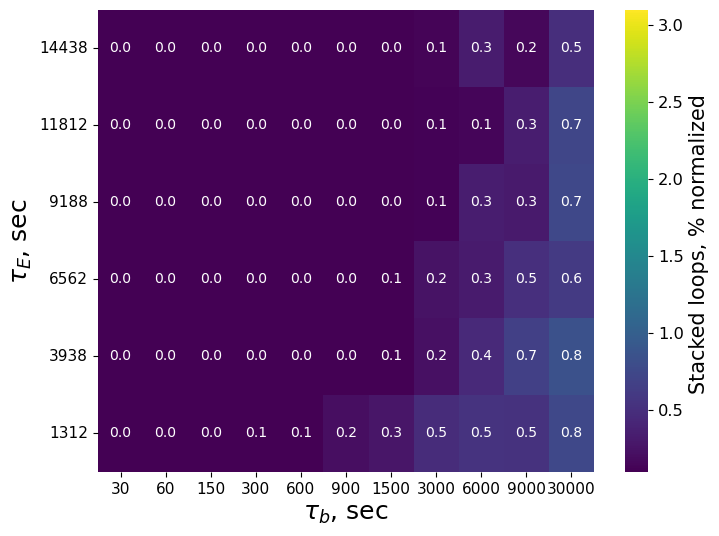

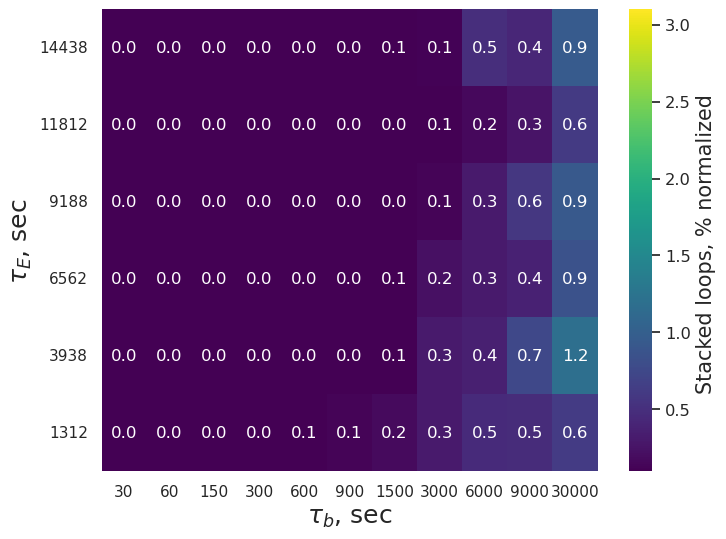

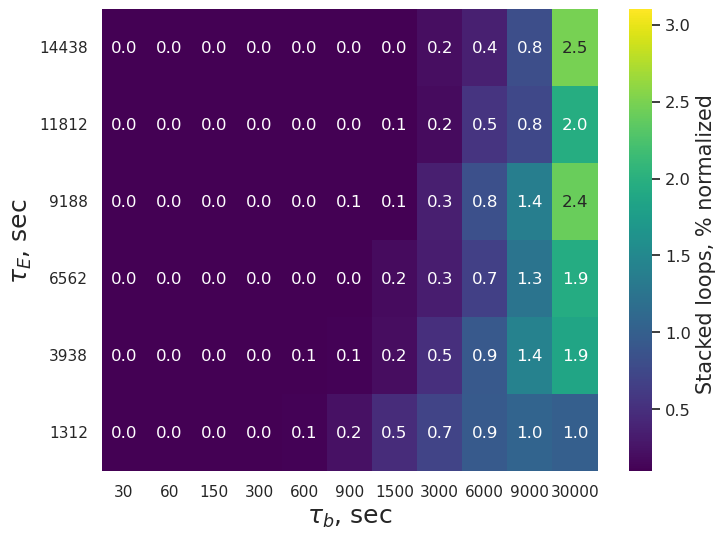

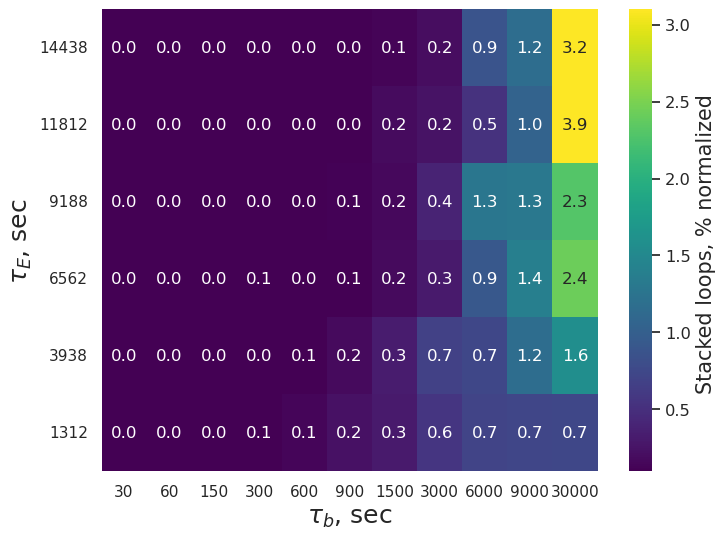

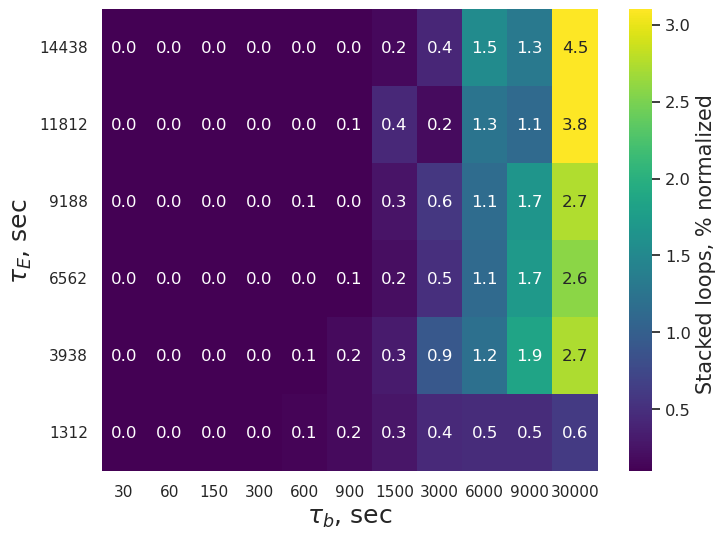

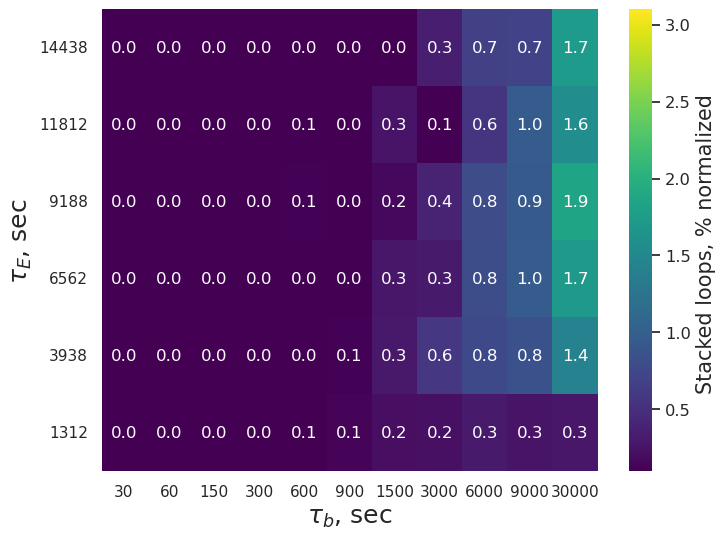

In [5]:
for mers in [1, 2, 3,4, 5,6]:
    file = pd.read_csv('../output/scores/simulation/loops/loops_and_stacks_pass_%sctcf_1frame.csv'%mers)
    file = file.drop_duplicates()
    lifetime = file['life']
    velocity = file[' vel']
    clife = file[' clife']
    cof = file[' cof']
    unique_life = np.unique(lifetime)
    unique_vel = np.unique(velocity)
    unique_clife = np.unique(clife)
    unique_cof = np.unique(cof)
    file['occupancy'] = (file[' clife']/(file[' clife']+file[' cof'])).round(2)
    n = normalizer_factor['%s_kmer'%mers]
    file[' stack_'] = (file[' stack']/n)*100
    convertor = 21.875*60/500
    for vel in list(unique_vel):
        file_70 = file[file['occupancy']==0.7]
        new_file = file_70[(velocity == vel)&(clife<100000)&(clife>=0.15)][['life',' clife',' sep',' cof',' stack_']]
        new_file['life']=(new_file['life']*convertor).round()
        new_file[' clife']=(new_file[' clife']*convertor).round()
        new_file_aggregated = (
        new_file.groupby(['life', ' clife'], as_index=False)[' stack_'].mean()
    )
        heatmap_data = new_file_aggregated.pivot('life', ' clife', ' stack_')
        heatmap_data = heatmap_data.astype(float)
        
        # Create the heatmap using seaborn
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(
            heatmap_data, annot=True, cmap='viridis', vmax=3.1, vmin =0.098,
            fmt='0.1f',cbar_kws={'label': 'oop stack at barreirs, normalized'}
        )
        sns.set(font_scale=1)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.75)
        cbar.set_label('Stacked loops, % normalized ', fontsize=15)
    
        d = gaussian_filter(heatmap_data.to_numpy(), sigma=1)
        smooth_scale = 1
        # Format tick labels
        im.set_xticklabels(
            [int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_xticklabels()])
        im.set_yticklabels(
            [int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_yticklabels()])
        # Customize labels and title
        plt.xticks(fontsize =11, rotation=0)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize =16.5)
        plt.yticks(fontsize = 11, rotation = 0)
        plt.xlabel(r'$\tau_b$, sec', fontsize = 18)
        plt.ylabel(r'$\tau_E$, sec', fontsize =18)
        plt.gca().invert_yaxis()
        plt.savefig('../output/figures/convergent_with_total_%spass_stacked.pdf'%(mers), transparent = True, bbox_inches = 'tight')
        plt.show()

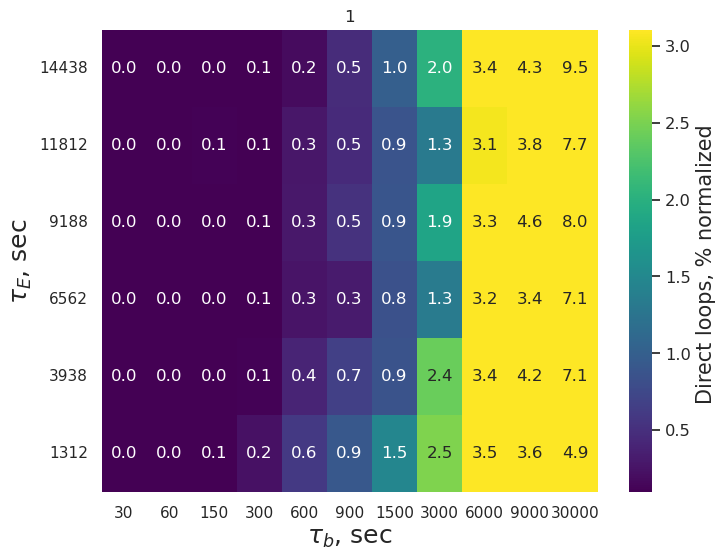

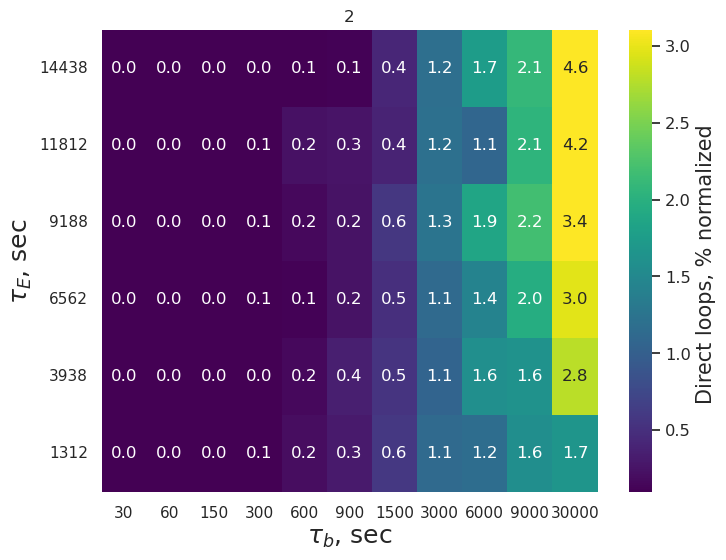

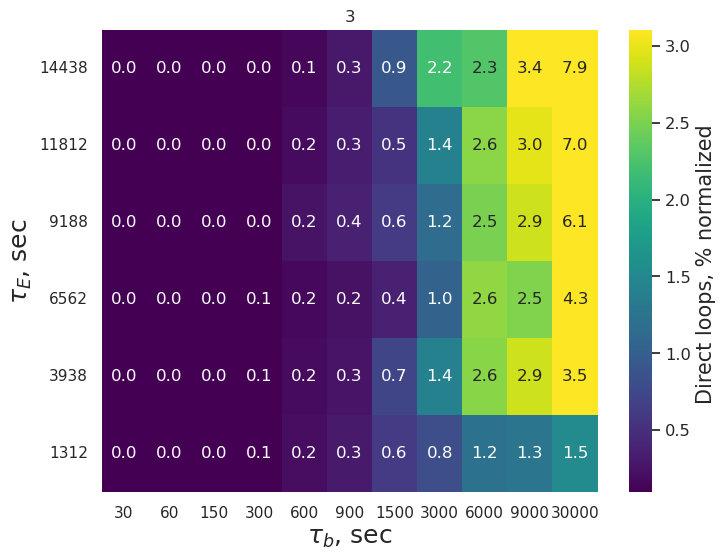

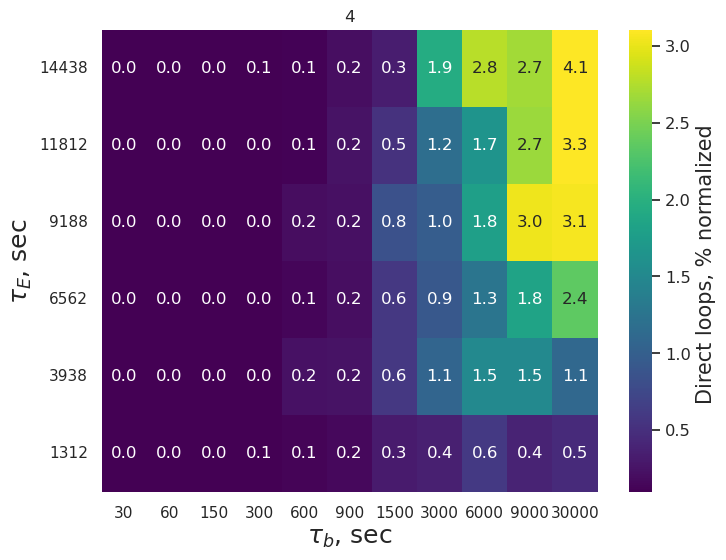

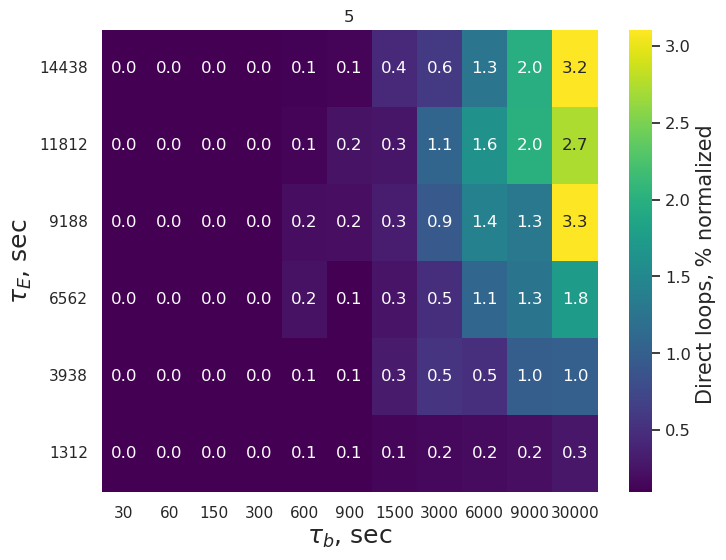

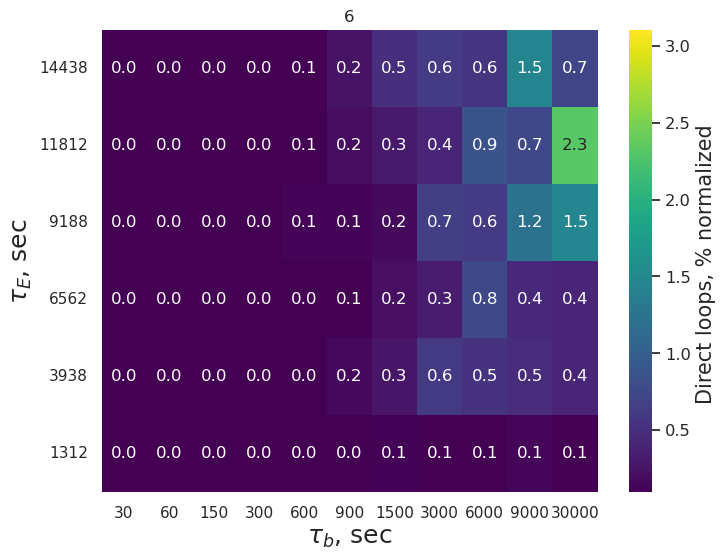

In [6]:
for mers in [1, 2, 3,4, 5,6]:
    file = pd.read_csv('../output/scores/simulation/loops/loops_and_stacks_pass_%sctcf_1frame.csv'%mers)
    file = file.drop_duplicates()
    lifetime = file['life']
    velocity = file[' vel']
    clife = file[' clife']
    cof = file[' cof']
    unique_life = np.unique(lifetime)
    unique_vel = np.unique(velocity)
    unique_clife = np.unique(clife)
    unique_cof = np.unique(cof)
    file['occupancy'] = (file[' clife']/(file[' clife']+file[' cof'])).round(2)
    n = normalizer_factor['%s_kmer'%mers]
    file[' %spass_'%mers] = (file[' %spass'%mers]/n)*100
    convertor = 21.875*60/500
    for vel in list(unique_vel):
        file_70 = file[file['occupancy']==0.7]
        new_file = file_70[(velocity == vel)&(clife<100000)&(clife>=0.15)][['life',' clife',' sep',' cof',' %spass_'%mers]]
        new_file['life']=(new_file['life']*convertor).round()
        new_file[' clife']=(new_file[' clife']*convertor).round()
        new_file_aggregated = (
        new_file.groupby(['life', ' clife'], as_index=False)[' %spass_'%mers].mean()
    )
        heatmap_data = new_file_aggregated.pivot('life', ' clife', ' %spass_'%mers)
        heatmap_data = heatmap_data.astype(float)
        
        # Create the heatmap using seaborn
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(
            heatmap_data, annot=True, cmap='viridis', vmax=3.1, vmin =0.098,
            fmt='0.1f',cbar_kws={'label': 'oop stack at barreirs, normalized'}
        )
        sns.set(font_scale=1)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.75)
        cbar.set_label('Direct loops, % normalized ', fontsize=15)
    
        # Add equipotential lines for loop size = 700
        d = gaussian_filter(heatmap_data.to_numpy(), sigma=1)
        smooth_scale = 1
        # Format tick labels
        im.set_xticklabels(
            [int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_xticklabels()])
        im.set_yticklabels(
            [int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_yticklabels()])
        # Customize labels and title
        plt.xticks(fontsize =11, rotation=0)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize =16.5)
        plt.yticks(fontsize = 11, rotation = 0)
        plt.xlabel(r'$\tau_b$, sec', fontsize = 18)
        plt.ylabel(r'$\tau_E$, sec', fontsize =18)
        #plt.title(' velocity= %s, occupancy=0.9'%( vel), fontsize =11.5)
        plt.title(mers)
        plt.gca().invert_yaxis()
        plt.savefig('../output/figures/convergent_with_atotal_%spass.pdf'%(mers), transparent = True, bbox_inches = 'tight')
        plt.show()

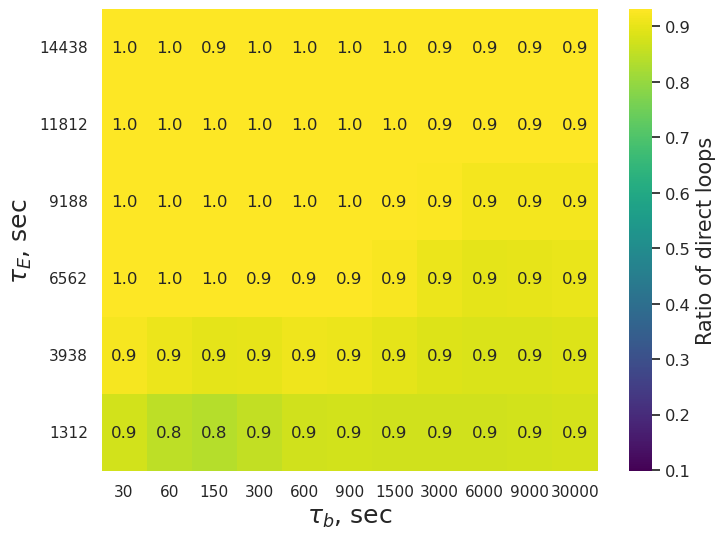

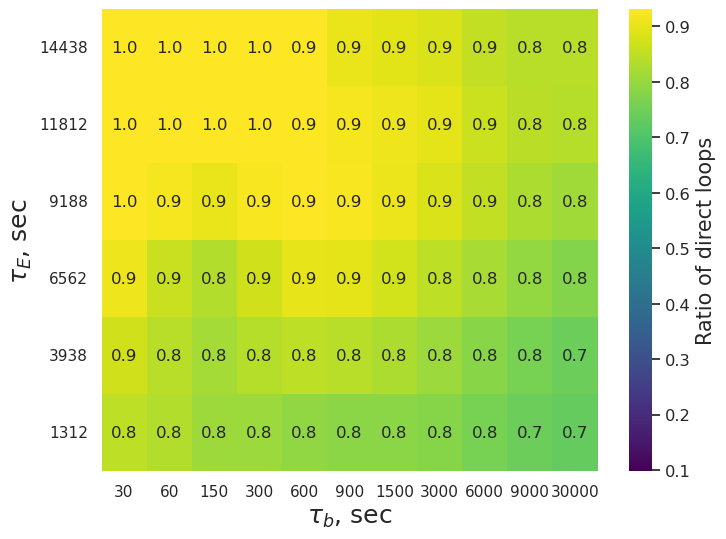

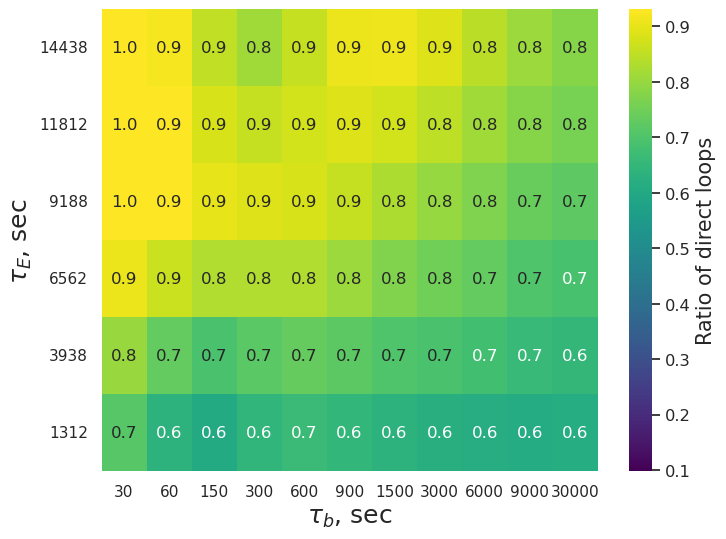

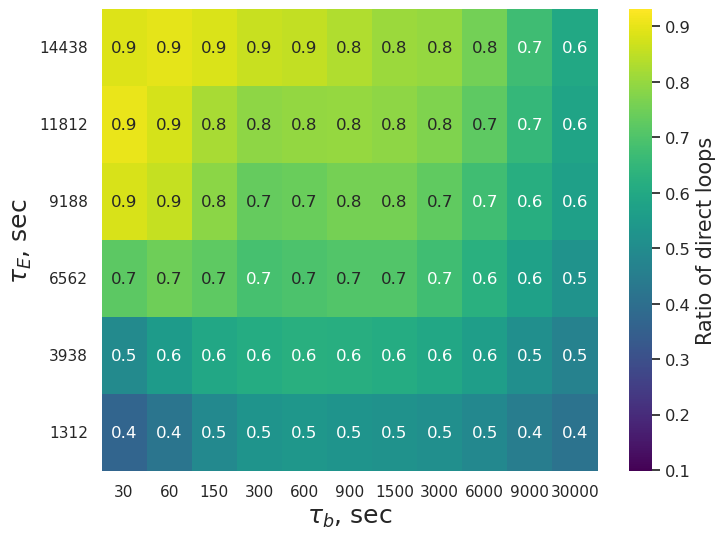

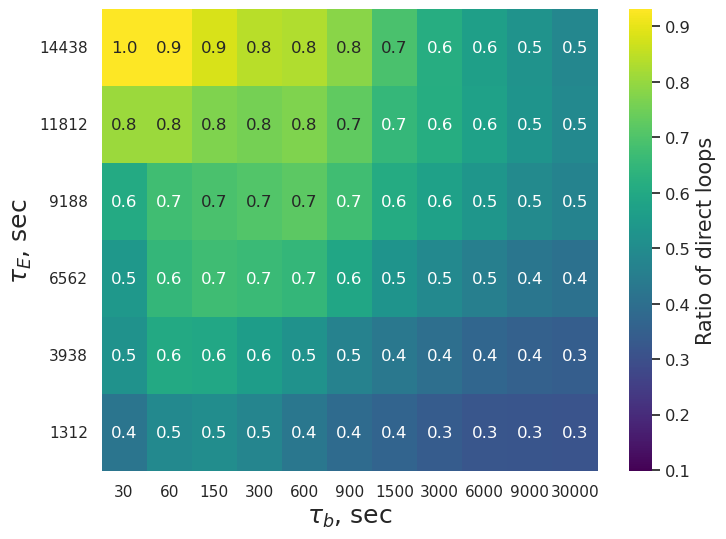

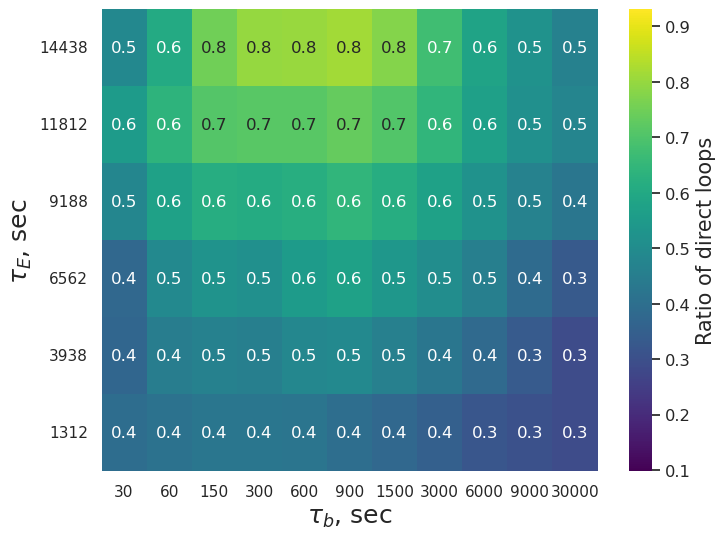

In [7]:
for mers in [1, 2, 3,4, 5,6]:
    file = pd.read_csv('../output/scores/simulation/loops/loops_and_stacks_pass_%sctcf_1frame.csv'%mers)
    file = file.drop_duplicates()
    lifetime = file['life']
    velocity = file[' vel']
    clife = file[' clife']
    cof = file[' cof']
    unique_life = np.unique(lifetime)
    unique_vel = np.unique(velocity)
    unique_clife = np.unique(clife)
    unique_cof = np.unique(cof)
    file['occupancy'] = (file[' clife']/(file[' clife']+file[' cof'])).round(2)
    n = normalizer_factor['%s_kmer'%mers]
    file[' passostack'] = (file[' %spass'%mers])/(file[' %spass'%mers]+file[' stack'])
    convertor = 21.875*60/500
    for vel in list(unique_vel):
        file_70 = file[file['occupancy']==0.7]
        new_file = file_70[(velocity == vel)&(clife<100000)&(clife>=0.15)][['life',' clife',' sep',' cof',' passostack']]
        new_file['life']=(new_file['life']*convertor).round()
        new_file[' clife']=(new_file[' clife']*convertor).round()
        new_file_aggregated = (
        new_file.groupby(['life', ' clife'], as_index=False)[' passostack'].mean()
    )
        heatmap_data = new_file_aggregated.pivot('life', ' clife', ' passostack')
        heatmap_data = heatmap_data.astype(float)
        
        # Create the heatmap using seaborn
        plt.figure(figsize=(8, 6))
        heatmap_data_smoothed = gaussian_filter(heatmap_data, sigma=1)
        im = sns.heatmap(
            heatmap_data_smoothed, annot=True, cmap='viridis', vmax=0.931, vmin =0.098,
            fmt='0.1f',cbar_kws={'label': 'oop stack at barreirs, normalized'}
        )
        sns.set(font_scale=1)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.75)
        cbar.set_label('Ratio of direct loops', fontsize=15)
    
        # Add equipotential lines for loop size = 700
        d = gaussian_filter(heatmap_data.to_numpy(), sigma=1)
        smooth_scale = 1
        # Restore original labels
        x_labels = heatmap_data.columns.to_list()
        y_labels = heatmap_data.index.to_list()
        im.set_xticks(np.arange(len(x_labels)) + 0.5)
        im.set_yticks(np.arange(len(y_labels)) + 0.5)
        im.set_xticklabels(x_labels, rotation=0, fontsize=11)
        im.set_yticklabels(y_labels, rotation=0, fontsize=11)
        # Format tick labels
        im.set_xticklabels(
            [int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_xticklabels()])
        im.set_yticklabels(
            [int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_yticklabels()])
        # Customize labels and title
        plt.xticks(fontsize =11, rotation=0)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize =16.5)
        plt.yticks(fontsize = 11, rotation = 0)
        plt.xlabel(r'$\tau_b$, sec', fontsize = 18)
        plt.ylabel(r'$\tau_E$, sec', fontsize =18)
        #plt.title(' velocity= %s, occupancy=0.9'%( vel), fontsize =11.5)
        plt.gca().invert_yaxis()
        plt.savefig('../output/figures/ratio_for_pass_convergent_%spass.pdf'%(mers), transparent = True, bbox_inches = 'tight')
        # Show the plot
        plt.show()